# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).


The environment for this project is [Tennis](https://github.com/udacity/deep-reinforcement-learning/tree/master/p3_collab-compet) from Unity, and it's provided in the `setup` folder.

![final](imgs/gif_2.gif "final")

> The model used to generate this gif is `final.pth` (Dueling Double DQN), which was trained for 700 episodes using `main.py`.

## 1. Prepare dependencies and environment

Take a look at README.md before executing this notebook and make sure that the kernel is set to **p3_collab_compet**.

In [1]:
!pip -q install ./setup

import sys
import platform

import numpy as np
from numpy_ringbuffer import RingBuffer
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

from setup import unityagents
from unityagents import UnityEnvironment

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Unity environments contain **brains**, our interfaces for controlling agents. We'll be conrtolling the first (default) brain in the environment. It's also useful to keep information such as `state_size`, `action_size` and `num_agents`.

In [2]:
env = None
system = platform.system()
if system == 'Linux':
    env = UnityEnvironment(file_name="setup/Tennis_Linux/Tennis.x86_64")
elif system == 'Darwin':
    env = UnityEnvironment(file_name="setup/Tennis.app")
elif system == 'Windows':
    env = UnityEnvironment(file_name="setup/Tennis_Windows_x86_64/Tennis.exe")
else:
    print('Cannot find environment for this system.')

# use the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

# 4 12 20 ?

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 2. Replay buffer

In [3]:
class UniformReplayBuffer():

    def __init__(self, capacity):
        self.capacity = capacity
        self.reset()
    
    def reset(self):
        self.buff = RingBuffer(capacity=self.capacity, dtype=object)
    
    def sample(self, n, replace=True):
        samples = np.random.choice(np.array(self.buff), n, replace)
        
        s = torch.FloatTensor([sample[0] for sample in samples]).to(device)
        a = torch.LongTensor([sample[1] for sample in samples]).to(device)
        r = torch.FloatTensor([sample[2] for sample in samples]).to(device)
        ns = torch.FloatTensor([sample[3] for sample in samples]).to(device)
        d = torch.FloatTensor([sample[4] for sample in samples]).to(device)
        
        return s, a, r, ns, d
    
    def add(self, observation):
        s, a, r, ns, d = observation
        self.buff.append((s, a, r, ns, d))
    
    def size(self):
        return len(self.buff)

## 3. Actor

In [4]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers=[64, 128, 64]):
        super(Actor, self).__init__()
        self.action_size = action_size

        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])

        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])

        # the actor will output a that maximizes Q(s, a)
        self.mu_layer = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, state):
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.relu(state)
        mu = self.mu_layer(state)
        return mu

## 4. Critic

In [5]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, number_of_agents, hidden_layers=[64, 128, 64]):
        super(Critic, self).__init__()

        # prepare the first hidden layer which receives states and actions for all agents
        self.hidden_layers = nn.ModuleList([nn.Linear((state_size + action_size) * number_of_agents, hidden_layers[0])])

        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])

        # the critic outputs only a scalar Q(s, a)
        self.value_layer = nn.Linear(hidden_layers[-1], 1)

    def forward(self, states, actions):
        # print(states.size(), actions.size())
        x = torch.cat((states, actions), dim=1)
        x = x.view(-1)
        # print(x.size())
        
        # connect layers to each other and put relu activations between them
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)
        value = self.value_layer(x)
        return value

## 5. Multi-Agent DDPG with self-play

In [6]:
class MADDPG:
    
    # -- initialization -- #

    def __init__(self, state_size, action_size, num_agents, replay_buffer,
                 update_every=15, batch_size=64, alpha=0.0001, gamma=0.95, tau=0.25):
        self.state_size, self.action_size, self.num_agents = state_size, action_size, num_agents
        self.update_every, self.batch_size = update_every, batch_size
        self.replay_buffer = replay_buffer
        self.alpha, self.gamma, self.tau = alpha, gamma, tau
        self.reset()

    def reset(self):        

        self.actor, self.target_actor = Actor(self.state_size, self.action_size).to(device), \
                                        Actor(self.state_size, self.action_size).to(device)
        self.critic, self.target_critic = Critic(self.state_size, self.action_size, self.num_agents).to(device), \
                                          Critic(self.state_size, self.action_size, self.num_agents).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.alpha)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.alpha)

        self.replay_buffer.reset()
        self.update_i = 0

    # -- initialization -- #
    
    def act(self, state):
        state = torch.FloatTensor(state).to(device)      
        action = self.actor(state)
        
        # add noise
        action = np.array(action.detach())
        action = action + np.random.normal(size=np.shape(action))
        
        return np.clip(action, -1, 1)
    
    def store(self, s, a, r, ns, d):
        # store a new experience
        self.replay_buffer.add((s, a, r, ns, d))

        if self.update_i == 0 and self.replay_buffer.size() >= self.batch_size:
            self.learn()

        self.update_i = (self.update_i + 1) % self.update_every

    def learn(self):
        # note that this is called automatically by the agent

        # sample tuples of experiences from memory (each of these variables is a torch tensor)
        s, a, r, ns, d = self.replay_buffer.sample(self.batch_size)

## 6. Training an agent

In [7]:
agents = [('MADDPG-SP', MADDPG(state_size, action_size, num_agents, UniformReplayBuffer(100_000)))]

In [8]:
def execute_episode(agent, env):
    # prepare the environment
    scores = np.zeros(num_agents)
    env_info = env.reset(train_mode=True)[brain_name]
    
    # get the initial state
    states = env_info.vector_observations
    while True:

        # evaluate the current state
        actions = agent.act(states)

        # execute the chosen action and get the outcome
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # store the experience (also automatically learn, from time to time)
        agent.store(states, actions, rewards, next_states, dones)

        # prepare for the next iteration
        states = next_states
        scores += rewards

        if np.any(dones):
            break
    
    # return the total rewards obtained
    return np.mean(scores)

In [9]:
def train(agent, env, episodes=200, repeat=1, consecutive_episodes=100, show_output=True, save_as=None):

    results = [None] * repeat
    for r in range(repeat):
        partial_results = [None] * episodes

        # reset the agent to start learning from scratch
        agent.reset()
        for i in range(episodes):

            # execute all the episodes and store the results
            score = execute_episode(agent, env)
            partial_results[i] = score
            
            if show_output:
                print("\r[{}] Episode: {}, Score: {}".format(r+1, i+1, score), end="")
                sys.stdout.flush()
        if show_output:
            print()

        results[r] = partial_results

        # store the trained model if requested
        if save_as is not None:
            torch.save(agent.actor.state_dict(), '{}/{}_actor.pth'.format(save_as, r+1))
            torch.save(agent.critic.state_dict(), '{}/{}_critic.pth'.format(save_as, r+1))

    # use convolutions to calculate the mean and standard deviation summarizing the training step
    results = np.array(results)
    mean = signal.convolve2d(results, np.ones([repeat, consecutive_episodes]) / (repeat * consecutive_episodes), mode='valid')    
    v = signal.convolve2d(results, np.ones([1, consecutive_episodes]) / consecutive_episodes, mode='valid')
    std_dev = signal.convolve2d(v ** 2 - mean ** 2, np.ones([repeat, 1]) / repeat, mode='valid') ** (1/2)
    return mean.flatten(), std_dev.flatten(), results

In [10]:
training_results = []
for ag in agents:
    name, agent = ag
    print('Agent: {}'.format(name))
    mean, std_dev, full_report = train(agent, env, save_as='models/{}'.format(name.replace(" ", "_")))
    training_results.append((mean, std_dev, full_report))
env.close()

Agent: MADDPG-SP
[1] Episode: 200, Score: -0.004999999888241291


## 7. Comparing the results

MADDPG-SP: Solved after 100 episodes


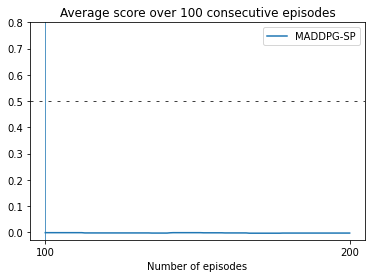

In [11]:
def plot_results(agents, training_results):
    for agent, ts in zip(agents, training_results):
        mean, std_dev, _ = ts
        episode_solved = np.argmax(mean > 0.5) + 100
        print('{}: Solved after {} episodes'.format(agent[0], episode_solved))

        x = np.arange(100, 100 + mean.size)
        line = plt.plot(x, mean, label = agent[0])
        plt.fill_between(x, mean + std_dev, mean - std_dev, alpha=0.25)
        plt.axvline(episode_solved, lw=0.75, color=line[0].get_color())

    plt.axhline(0.5, dashes=(4, 8), lw=0.75, color='black')
    plt.xticks(np.arange(1, 1 + mean.size / 100) * 100)
    plt.yticks(np.arange(0, 9) / 10)
    plt.xlabel('Number of episodes')
    plt.title('Average score over 100 consecutive episodes')
    plt.legend()
    plt.show()

plot_results(agents[:1], training_results[:1])
# plot_results(agents[2:], training_results[2:])